# Useful libraries

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the tree class and the associated methods

In [2]:
class Tree:
    def __init__(self, idx, depth=0, nbVisit=0, tot=0, bound=1e9, father=None, leftChild=None, rightChild=None, leaf=None):
        self.idx = idx
        self.depth=depth
        self.nbVisit = nbVisit
        self.tot = tot
        self.bound = bound
        self.father = father
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.leaf = leaf
    
    
    def __str__(self):
        res = """Id: {}\nDepth: {}\nNumber of visits: {}\nSum of rewards: {}\nCurrent upper bound: {}\nLeaf: {}\n
        """.format(self.idx, self.depth, self.nbVisit, self.tot, self.bound, str(self.leaf))
        return res
    
    
    def build(self, fatherDict, childrenDict, leafDict):
        nodeList = [self]
        nbNodes = len(fatherDict)+1
        # set fathers and children
        for i in range(1, nbNodes):
            nodeList.append(Tree(i, depth=nodeList[fatherDict[i]].depth+1, father=nodeList[fatherDict[i]]))
        # set children
        for i in childrenDict:
            nodeList[i].leftChild = nodeList[childrenDict[i][0]]
            nodeList[i].rightChild = nodeList[childrenDict[i][1]]
        # set leaves
        for i in leafDict:
            nodeList[i].leaf = leafDict[i]
        leafList = [e for e in nodeList if e.idx in leafDict]
        return nodeList, leafList
    
    
    def build_comb(self, D):
        d = self.depth
        if d == D-1:
            lC = Tree(idx=self.idx+1, depth=d+1, father=self, leaf=ConstantLeaf(0))
            rC = Tree(idx=self.idx+2, depth=d+1, father=self, leaf=ConstantLeaf(1))
            self.leftChild = lC
            self.rightChild = rC
        else:
            lC = Tree(idx=self.idx+1, depth=d+1, father=self, leaf=ConstantLeaf((D-d-1)/D))
            rC = Tree(idx=self.idx+2, depth=d+1, father=self)
            self.leftChild = lC
            self.rightChild = rC
            self.rightChild.build_comb(D)
    
    
    def build_smooth(self, D, inf=0, sup=1, delta=1, gamma=0.5):
        if self.depth == D:
            self.leaf = BernoulliLeaf(p=inf+(sup-inf)*np.random.rand())
        
        else:
            radius = delta*gamma**(self.depth)/2
            new_center = inf + (sup-inf)*np.random.rand()
            if new_center - radius < inf:
                new_inf = inf
                new_sup = new_inf + 2*radius
            elif new_center + radius > sup:
                new_sup = sup
                new_inf = new_sup - 2*radius
            else:
                new_inf = new_center - radius
                new_sup = new_center + radius
            self.leftChild = Tree(idx=self.idx+1, depth=self.depth+1, father=self)
            self.rightChild = Tree(idx=self.idx+2**(D-self.depth), depth=self.depth+1, father=self)
            self.leftChild.build_smooth(D, new_inf, new_sup, delta, gamma)
            self.rightChild.build_smooth(D, new_inf, new_sup, delta, gamma)
    
    
    def build_bernoulli(self, p, maxD):
        u = np.random.rand()
        if ((u < p) or (self.depth == 0)) and (self.depth < maxD):
            self.leftChild = Tree(0, depth=self.depth+1, father=self)
            self.rightChild = Tree(0, depth=self.depth+1, father=self)
            self.leftChild.build_bernoulli(p, maxD)
            self.rightChild.build_bernoulli(p, maxD)
        else:
            m = np.random.rand()
            self.leaf = BernoulliLeaf(m)
    
    
    
    def UCT_update(self, r, bound_function, visited=True):
        if visited:
            self.tot += r
            self.nbVisit += 1
        if (self.father != None) and (self.nbVisit > 0):
            self.bound = self.tot/self.nbVisit + bound_function(self.nbVisit, self.father.nbVisit)
    
    
    def modifiedUCT_update(self, r, D, beta, bound_function):
        self.tot += r
        self.nbVisit += 1
        if self.father != None:
            self.bound = self.tot/self.nbVisit + bound_function(D, self.depth, self.nbVisit, beta)
    
    
    def flatUCT_update(self, r, D, beta, bound_function):
        self.nbVisit += 1
        if self.leaf == None:
            self.bound = np.max([self.leftChild.bound, self.rightChild.bound])
        else:
            self.tot += r
            self.bound = self.tot/self.nbVisit + bound_function(D, self.nbVisit, beta)
    
    
    def smooth_update(self, r, D, beta, delta, gamma, bound_function):
        self.tot += r
        self.nbVisit += 1
        n = self.nbVisit
        c = bound_function(n, D, beta)
        if self.leaf == None:
            delta_d = delta*gamma**(self.depth)
            self.bound = min(max(self.leftChild.bound, self.rightChild.bound),
                            self.tot/self.nbVisit + delta_d + c)
        else:
            self.bound = self.tot/self.nbVisit + c
    
    
    def find_best_arm(self):
        if self.leaf == None:
            return max(self.leftChild.find_best_arm(), self.rightChild.find_best_arm())
        else:
            return self.leaf.p
    
    
    def find_depth(self):
        if self.leaf == None:
            return max(self.leftChild.find_depth(), self.rightChild.find_depth())
        else:
            return self.depth
        
    
    def find_param_leafs(self):
        if self.leaf != None:
            return [self.leaf.p]
        else:
            return self.rightChild.find_param_leafs() + self.leftChild.find_param_leafs()

# Define different classes of leaves

In [3]:
class NormalLeaf:
    def __init__(self, p, std):
        self.p = p
        self.std = std
    
    def __str__(self):
        return "Normal distribution with mean {} and standard deviation {}".format(self.p, self.std)
    
    def sample(self):
        return np.random.normal(self.p, self.std)


class BernoulliLeaf:
    def __init__(self, p):
        self.p = p
    
    def __str__(self):
        return "Bernoulli distribution with parameter {}".format(self.p)
    
    def sample(self):
        return np.random.binomial(1, self.p)


class ConstantLeaf:
    def __init__(self, p):
        self.p = p
    
    def __str__(self):
        return "This leaf returns a constant value {}".format(self.p)
    
    def sample(self):
        return self.p

# The UCT algorithm

In [4]:
def UCT_bound_function_log(n, p):
    return np.sqrt(2*np.log(p)/n)


def UCT_bound_function_sqrt(n, p):
    return np.sqrt(np.sqrt(p)/n)


def modifiedUCT_bound_function(D, d, n, beta):
    kd = (1 + np.sqrt(2))/np.sqrt(2)*((1 + np.sqrt(2))**(D-d) - 1)
    kdprime = (3**(D-d) - 1)/2
    N = 2**(D+1) - 1
    betan = beta/(2*N*n*(n+1))
    res = (kd + 1)*np.sqrt(np.log(1/betan)/(2*n))+ kdprime/n
    return res


def flatUCT_bound_function(D, n, beta):
    betan = beta/(2**(D+1)*n*(n+1))
    res = np.sqrt(np.log(1/betan)/(2*n))
    return res


def smooth_bound_function(n, D, beta):
    N = 2**(D+1) - 1
    return np.sqrt(np.log(2*N*n*(n+1)/beta)/(2*n))


def UCT(root, N_iter, bound_function, mode='classic', D=0, beta=0.05, delta=1, gamma=0.5):
    
    # Reward
    R = 0
    Rlist = []
    # N_iter paths
    for i in range(N_iter):
        currentNode = root
        
        # sample a trajectory
        traj = [root]
        traj_not_visited = [] # nodes whose father is in the trajectory must be updated
        while currentNode.leaf == None:
            if currentNode.leftChild.bound < currentNode.rightChild.bound:
                traj_not_visited.append(currentNode.leftChild)
                currentNode = currentNode.rightChild
            else:
                traj_not_visited.append(currentNode.rightChild)
                currentNode = currentNode.leftChild
            traj.append(currentNode)
        
        # once in a leaf, sample a reward
        r = currentNode.leaf.sample()
        R += r
        Rlist.append(R)
        # update the whole trajectory
        if mode == 'classic':
            for node in traj:
                node.UCT_update(r, bound_function)
            for node in traj_not_visited:
                node.UCT_update(r, bound_function, visited=False)
        elif mode == 'modified':
            for node in traj:
                node.modifiedUCT_update(r, D, beta, bound_function)
        elif mode == 'flat':
            for node in reversed(traj):
                node.flatUCT_update(r, D, beta, bound_function)
        elif mode == 'smooth':
            for node in reversed(traj):
                node.smooth_update(r, D, beta, delta, gamma, bound_function)
                
        
    # find the best path
    currentNode = root
    path = [root]
    while currentNode.leaf == None:
        if currentNode.leftChild.bound < currentNode.rightChild.bound:
            currentNode = currentNode.rightChild
        else:
            currentNode = currentNode.leftChild
        path.append(currentNode)
    
    return R, Rlist, path

# Plot the regrets of different algorithms

In [5]:
def compare_regrets(cumR_list, legend, withbound=False, lbound=[]):
    plt.figure(figsize=(10,10))
    for Rl in cumR_list:
        plt.plot(np.array(Rl))
    if withbound:
        for bound in lbound:
            plt.plot(bound, '-')
    plt.legend(legend)
    plt.title('Cumulative regret with respect to iterations')
    plt.show()

# I. UCT with log-exploration vs. UCT with sqrt-exploration

### I.1. Comb tree

UCT with log-exploration...
UCT with sqrt-exploration...


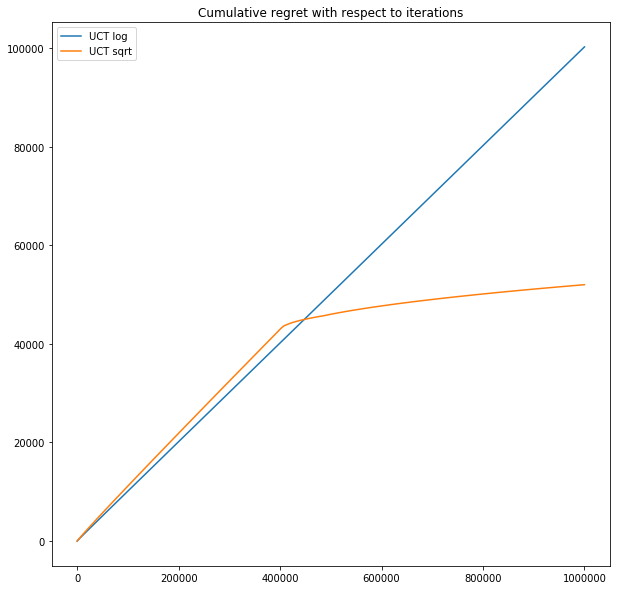

In [15]:
D = 10

print('UCT with log-exploration...')
root = Tree(0)
root.build_comb(D)
bound_function = UCT_bound_function_log
N_iter = 1000000
R1, Rlist1, path1 = UCT(root, N_iter, bound_function=bound_function, mode='classic')
best_arm_mean = root.find_best_arm()
Rlist1 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)]

print('UCT with sqrt-exploration...')
root = Tree(0)
root.build_comb(D)
bound_function = UCT_bound_function_sqrt
N_iter = 1000000
R2, Rlist2, path2 = UCT(root, N_iter, bound_function=bound_function, mode='classic')
Rlist2 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)]

cumR_list = [Rlist1, Rlist2]
legend = ['UCT log', 'UCT sqrt']
compare_regrets(cumR_list, legend)

### I.2. Bernoulli-defined tree
"Bernoulli-defined" tree: build the tree from the root; set a maximum depth; at each newborn node, set a leaf with probability $1-p$ or set two children with probability $p$ (unless the maximium depth is reached, then set a leaf).

UCT with log bound...
UCT with sqrt bound...


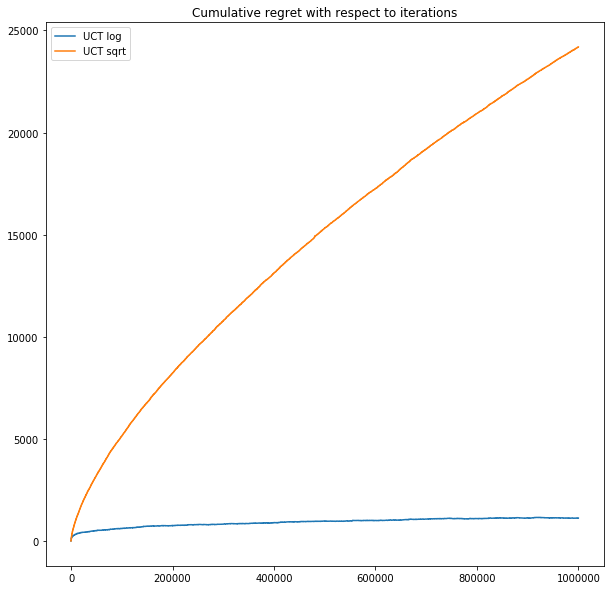

In [16]:
# Parameters
p = 0.7
maxD = 12
N_iter = 1000000


# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = UCT_bound_function_log
R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D)
best_arm_mean = root.find_best_arm()
Rlist1 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)]

print('UCT with sqrt bound...')
np.random.seed(0)
root = Tree(0)
root.build_bernoulli(p, maxD)
D = root.find_depth()
bound_function = UCT_bound_function_sqrt
R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D)
best_arm_mean = root.find_best_arm()
Rlist2 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)]

cumR_list = [Rlist1, Rlist2]
legend = ['UCT log', 'UCT sqrt']
compare_regrets(cumR_list, legend)

# II. Compare all the algorithms

### II.1. On a "Bernoulli" tree

UCT with log bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.67s/it]


UCT with sqrt bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.04s/it]


Modified UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.56s/it]


Flat UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]


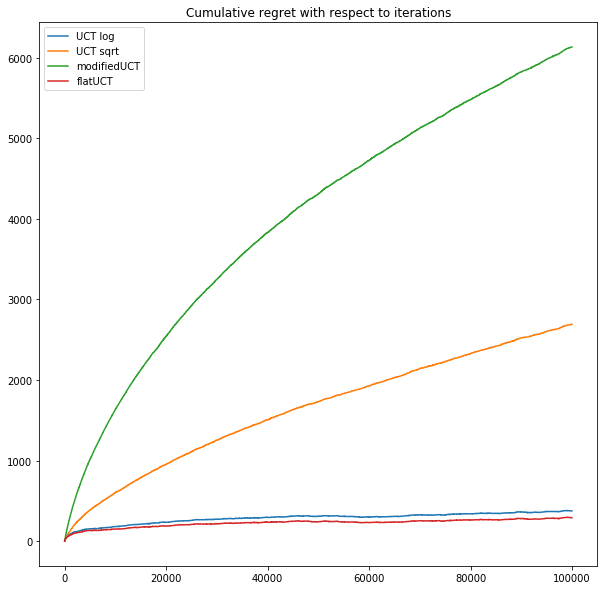

In [81]:
# Parameters
p = 0.7
maxD = 4
delta = 1
N_iter = 100000
beta = 0.01
N_sim = 10

# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
Rlist1_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = UCT_bound_function_log
    R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D)
    best_arm_mean = root.find_best_arm()
    Rlist1_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)])
Rlist1_mean = np.mean(Rlist1_mean, axis=0)

print('UCT with sqrt bound...')
np.random.seed(0)
Rlist2_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = UCT_bound_function_sqrt
    R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D)
    best_arm_mean = root.find_best_arm()
    Rlist2_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)])
Rlist2_mean = np.mean(Rlist2_mean, axis=0)

print('Modified UCT...')
np.random.seed(0)
Rlist3_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = modifiedUCT_bound_function
    R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist3_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist3)])
Rlist3_mean = np.mean(Rlist3_mean, axis=0)

print('Flat UCT...')
np.random.seed(0)
Rlist4_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_bernoulli(p, maxD)
    D = root.find_depth()
    bound_function = flatUCT_bound_function
    R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist4_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist4)])
Rlist4_mean = np.mean(Rlist4_mean, axis=0)

cumR_list = [Rlist1_mean, Rlist2_mean, Rlist3_mean, Rlist4_mean]
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT']
compare_regrets(cumR_list, legend)

### II.2. On a smooth tree

UCT with log bound...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [17:23<00:00, 104.40s/it]


UCT with sqrt bound...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:12<00:00, 91.23s/it]


Modified UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:46<00:00, 64.68s/it]


Flat UCT...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:29<00:00, 50.93s/it]


Bandit for smooth tree...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:11<00:00, 43.13s/it]


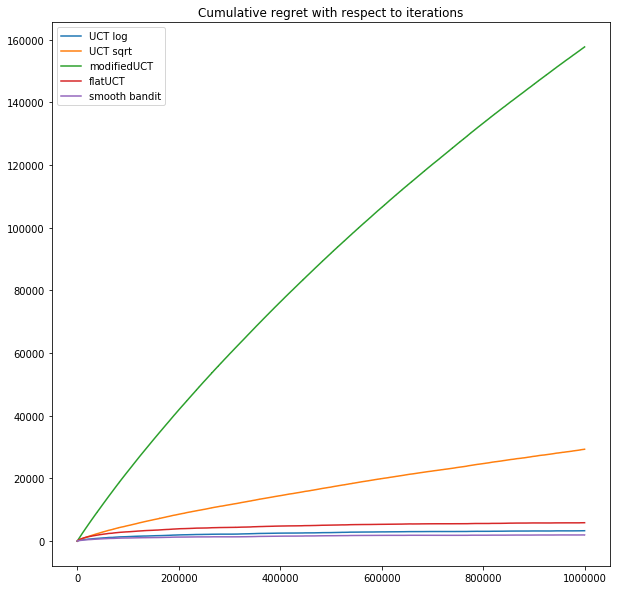

In [6]:
# Parameters
D = 6
delta = 1
gamma = 0.01
beta = 0.05
N_iter = 1000000
N_sim = 10

# Bandit algorithms

print('UCT with log bound...')
np.random.seed(0)
Rlist1_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = UCT_bound_function_log
    R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist1_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)])
Rlist1_mean = np.mean(Rlist1_mean, axis=0)

print('UCT with sqrt bound...')
np.random.seed(0)
Rlist2_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = UCT_bound_function_sqrt
    R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='classic', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist2_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)])
Rlist2_mean = np.mean(Rlist2_mean, axis=0)

print('Modified UCT...')
np.random.seed(0)
Rlist3_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = modifiedUCT_bound_function
    R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist3_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist3)])
Rlist3_mean = np.mean(Rlist3_mean, axis=0)

print('Flat UCT...')
np.random.seed(0)
Rlist4_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = flatUCT_bound_function
    R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)
    best_arm_mean = root.find_best_arm()
    Rlist4_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist4)])
Rlist4_mean = np.mean(Rlist4_mean, axis=0)

print('Bandit for smooth tree...')
np.random.seed(0)
Rlist5_mean = []
for j in tqdm(range(N_sim)):
    root = Tree(0)
    root.build_smooth(D)
    bound_function = smooth_bound_function
    R5, Rlist5, path5 = UCT(root, N_iter, bound_function, mode='smooth', D=D, beta=beta, delta=delta, gamma=gamma)
    best_arm_mean = root.find_best_arm()
    Rlist5_mean.append([best_arm_mean*(i+1)-e for i,e in enumerate(Rlist5)])
Rlist5_mean = np.mean(Rlist5_mean, axis=0)

cumR_list = [Rlist1_mean, Rlist2_mean, Rlist3_mean, Rlist4_mean, Rlist5_mean]
legend = ['UCT log', 'UCT sqrt', 'modifiedUCT', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, legend)

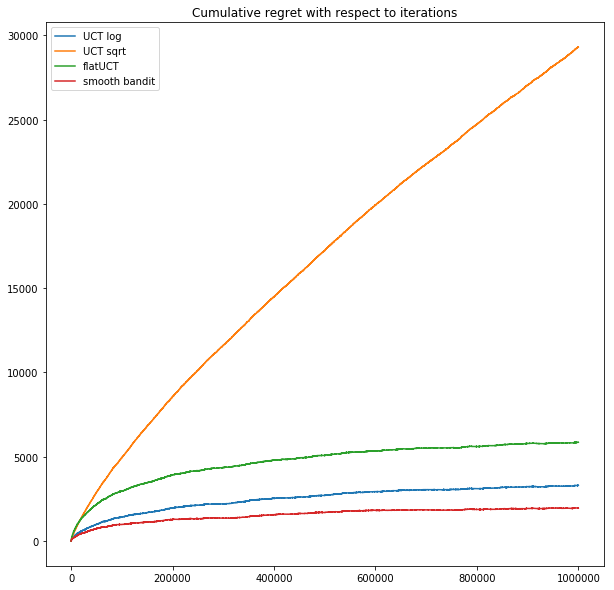

In [9]:
cumR_list = [Rlist1_mean, Rlist2_mean, Rlist4_mean, Rlist5_mean]
legend = ['UCT log', 'UCT sqrt', 'flatUCT', 'smooth bandit']
compare_regrets(cumR_list, legend)

### III. Plots with bounds on regret

In [52]:
def pseudo_regret_mod_UCT(tree, n, beta):
    '''
    parameters:
    - the tree
    - n : the number of trajectories used for the experiment
    - beta : the probability for the confidence bound
    Return:
    - res: a list containing the evolution of the pseudo-regret
    '''
    depth = tree.find_depth()
    res = []
    N = (2**(depth+1)-1)
    const = (1+np.sqrt(2))**depth
    const_2 = (3**depth -1)/2
    for i in range(1,n+1):
        b_n = beta/(2*i*(i+1)*N)
        res.append((1+np.sqrt(2))/2*(const - 1)*np.sqrt(np.log(1/b_n)*i) + const_2)
    return res


def pseudo_regret_flat_UCB(tree, n, beta, param_list):
    '''
    parameters:
    - the tree
    - n : the number of trajectories used for the experiment
    - beta : the probability for the confidence bound
    - param_list: list of parameters for the tree
    Return:
    - res: a list containing the evolution of the pseudo-regret
    '''
    mu_star = np.max(np.array(param_list))
    depth = tree.find_depth()
    Delta_list = []
    res = 0
    const = 2**(depth+2)
    for e in param_list:
        Delta_list.append(mu_star - e)
    
    for e in Delta_list:
        if e > 0:
            res += 6/e*np.log(const/(e*e*beta))
    return [res]*n


def pseudo_regret_BAST(tree, n, beta, param_list, eta, delta):
    '''
    parameters:
    - the tree
    - n : the number of trajectories used for the experiment
    - beta : the probability for the confidence bound
    - param_list: list of parameters for the tree
    - eta: the parameter used for the set of eta-optimal leaves
    - delta : the parameter for the exponential sequence
    Return:
    - res: a list containing the evolution of the pseudo-regret
    '''
    mu_star = np.max(np.array(param_list))
    depth = tree.find_depth()
    Delta_list = []
    temp = 0
    N = (2**(depth+1)-1)
    c = np.log(2)/np.log(1/delta)
    const = 54*(3*delta)**c/(eta**(2+c))*np.log(4*N/(eta**2*beta))
    for e in param_list:
        Delta_list.append(mu_star - e)
    
    for e in Delta_list:
        if (e > 0) and (e <= eta):
            temp += 6/e*np.log((4*N)/(e*e*beta)) + const
    return [temp]*n

Modified UCT beta=0.05...
UCT with sqrt bound beta=0.8...
Flat UCT beta=0.05...
Flat UCT beta=0.8...
BAST beta=0.05...
BAST beta=0.8...


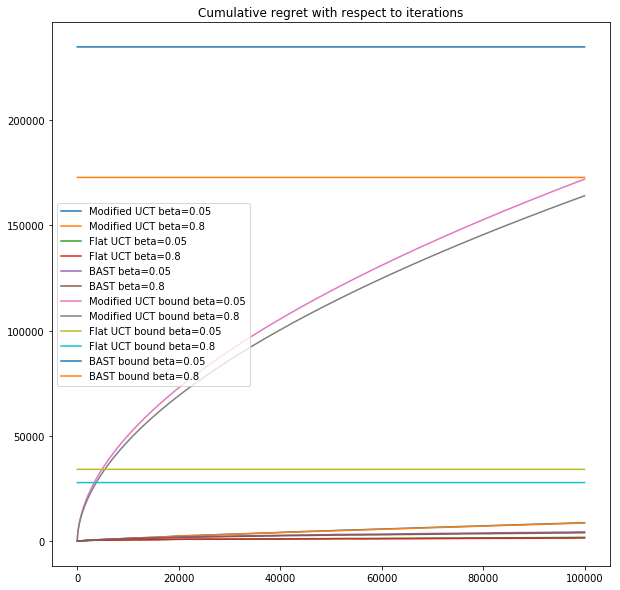

In [78]:
# Parameters
p = 0.7
D = 5
N_iter = 100000
delta = 0.5
gamma = 0.95


# Bandit algorithms

print('Modified UCT beta=0.05...')
beta = 0.05
np.random.seed(0)
root = Tree(0)
root.build_smooth(D, delta=delta, gamma=gamma)
D = root.find_depth()
bound_function = modifiedUCT_bound_function
R1, Rlist1, path1 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)
best_arm_mean = root.find_best_arm()
Rlist1 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist1)]

print('UCT with sqrt bound beta=0.8...')
beta = 0.8
np.random.seed(0)
root = Tree(0)
root.build_smooth(D, delta=delta, gamma=gamma)
D = root.find_depth()
bound_function = modifiedUCT_bound_function
R2, Rlist2, path2 = UCT(root, N_iter, bound_function, mode='modified', D=D, beta=beta)
best_arm_mean = root.find_best_arm()
Rlist2 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist2)]

print('Flat UCT beta=0.05...')
beta = 0.05
np.random.seed(0)
root = Tree(0)
root.build_smooth(D, delta=delta, gamma=gamma)
D = root.find_depth()
bound_function = flatUCT_bound_function
R3, Rlist3, path3 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)
best_arm_mean = root.find_best_arm()
Rlist3 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist3)]

print('Flat UCT beta=0.8...')
beta = 0.8
np.random.seed(0)
root = Tree(0)
root.build_smooth(D, delta=delta, gamma=gamma)
D = root.find_depth()
bound_function = flatUCT_bound_function
R4, Rlist4, path4 = UCT(root, N_iter, bound_function, mode='flat', D=D, beta=beta)
best_arm_mean = root.find_best_arm()
Rlist4 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist4)]

print('BAST beta=0.05...')
beta = 0.05
np.random.seed(0)
root = Tree(0)
root.build_smooth(D, delta=delta, gamma=gamma)
D = root.find_depth()
bound_function = smooth_bound_function
R5, Rlist5, path5 = UCT(root, N_iter, bound_function, mode='smooth', D=D, beta=beta, delta=delta, gamma=gamma)
best_arm_mean = root.find_best_arm()
Rlist5 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist5)]

print('BAST beta=0.8...')
beta = 0.8
np.random.seed(0)
root = Tree(0)
root.build_smooth(D, delta=delta, gamma=gamma)
D = root.find_depth()
bound_function = smooth_bound_function
R6, Rlist6, path6 = UCT(root, N_iter, bound_function, mode='smooth', D=D, beta=beta, delta=delta, gamma=gamma)
best_arm_mean = root.find_best_arm()
Rlist6 = [best_arm_mean*(i+1)-e for i,e in enumerate(Rlist6)]

param_list = root.find_param_leafs()
eta = 0.5
prflat = pseudo_regret_flat_UCB(root, N_iter, 0.05, param_list)
prbast = pseudo_regret_BAST(root, N_iter, 0.05, param_list, eta, delta)
prflatbis = pseudo_regret_flat_UCB(root, N_iter, 0.8, param_list)
prbastbis = pseudo_regret_BAST(root, N_iter, 0.8, param_list, eta, delta)
cumR_list = [Rlist1, Rlist2, Rlist3, Rlist4, Rlist5, Rlist6]
legend = ['Modified UCT beta=0.05', 'Modified UCT beta=0.8', 'Flat UCT beta=0.05', 'Flat UCT beta=0.8', 'BAST beta=0.05', 'BAST beta=0.8',
          'Modified UCT bound beta=0.05', 'Modified UCT bound beta=0.8', 'Flat UCT bound beta=0.05', 'Flat UCT bound beta=0.8', 'BAST bound beta=0.05',
         'BAST bound beta=0.8']
lbound = [pseudo_regret_mod_UCT(root, N_iter, 0.05), pseudo_regret_mod_UCT(root, N_iter, 0.8),
         prflat, prflatbis, prbast, prbastbis]
compare_regrets(cumR_list, legend, withbound=True, lbound=lbound)

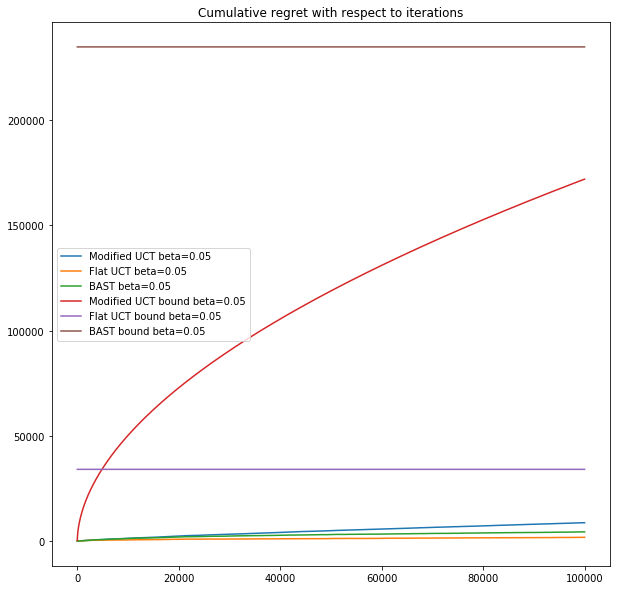

In [79]:
param_list = root.find_param_leafs()
eta = 0.5
prflat = pseudo_regret_flat_UCB(root, N_iter, 0.05, param_list)
prbast = pseudo_regret_BAST(root, N_iter, 0.05, param_list, eta, delta)
prflatbis = pseudo_regret_flat_UCB(root, N_iter, 0.8, param_list)
prbastbis = pseudo_regret_BAST(root, N_iter, 0.8, param_list, eta, delta)
cumR_list = [Rlist1, Rlist3, Rlist5]
legend = ['Modified UCT beta=0.05', 'Flat UCT beta=0.05',  'BAST beta=0.05', 
          'Modified UCT bound beta=0.05', 'Flat UCT bound beta=0.05', 'BAST bound beta=0.05']
lbound = [pseudo_regret_mod_UCT(root, N_iter, 0.05), prflat, prbast]
compare_regrets(cumR_list, legend, withbound=True, lbound=lbound)